In [1]:
# Cell 1: Environment Setup and Imports

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import joblib

# Reproducibility
RANDOM_STATE = 42

# Display settings
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

print("Setup complete. Ready to load the dataset.")

Setup complete. Ready to load the dataset.


In [2]:
# Cell 1: EDA Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency, mannwhitneyu

print("EDA libraries loaded.")

EDA libraries loaded.


In [3]:
# Auto-detect data file path
import os

# Try to find the CSV file in common locations
possible_paths = [
    "PS_20174392719_1491204439457_log.csv",  # Same directory
    "./PS_20174392719_1491204439457_log.csv",
    "../PS_20174392719_1491204439457_log.csv",
    "data/PS_20174392719_1491204439457_log.csv",
    "/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv"  # Kaggle path
]

DATA_PATH = None
for path in possible_paths:
    if os.path.exists(path):
        DATA_PATH = path
        print(f"[OK] Found data file at: {DATA_PATH}")
        break

if DATA_PATH is None:
    print("[ERROR] Data file not found!")
    print("\nPlease download the dataset from:")
    print("https://www.kaggle.com/datasets/ealaxi/paysim1")
    print("\nOr place the file 'PS_20174392719_1491204439457_log.csv' in:")
    print(os.getcwd())
    raise FileNotFoundError("Data file not found")

[OK] Found data file at: PS_20174392719_1491204439457_log.csv


In [4]:
# Cell 2: Load Dataset


df = pd.read_csv(DATA_PATH)

print("Dataset loaded.")
print("Shape:", df.shape)
df.head()

Dataset loaded.
Shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
# Cell 3: Basic Structure Checks

print("Columns:", list(df.columns))
print("\nData types and non-null counts:")
df.info()

print("\nMissing values (top 10):")
display(df.isna().sum().sort_values(ascending=False).head(10))

Columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']

Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB

Missing values (top 10):


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [6]:
# Cell 4: Define Target and Feature Groups

TARGET = "isFraud"

categorical_features = ["type", "isFlaggedFraud"]

numerical_features = [
    "step",
    "amount",
    "oldbalanceOrg",
    "newbalanceOrig",
    "oldbalanceDest",
    "newbalanceDest"
]

print("Target:", TARGET)
print("Categorical features:", categorical_features)
print("Numerical features:", numerical_features)

Target: isFraud
Categorical features: ['type', 'isFlaggedFraud']
Numerical features: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']


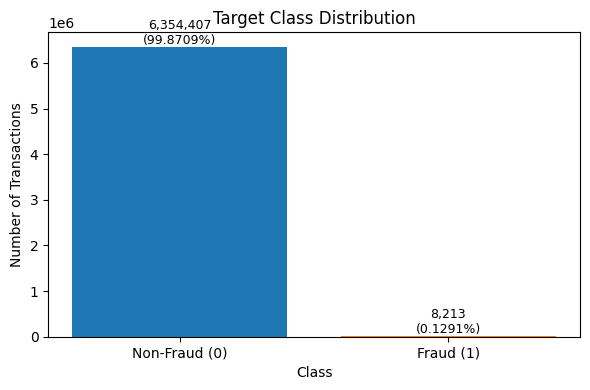

Fraud rate (%): 0.12908204481801522


In [7]:
# Cell 5: Target Distribution (Single Plot)

target_counts = df[TARGET].value_counts().sort_index()
target_percent = target_counts / target_counts.sum() * 100

plt.figure(figsize=(6, 4))
bars = plt.bar(
    ["Non-Fraud (0)", "Fraud (1)"],
    target_counts.values,
    color=["#1f77b4", "#ff7f0e"]  # blue and orange
)

plt.title("Target Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=0)

for bar, count, pct in zip(bars, target_counts.values, target_percent.values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{count:,}\n({pct:.4f}%)",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()

print("Fraud rate (%):", float(target_percent.get(1, 0.0)))

In [8]:
# Table Formatting Helpers 

def fmt_int(x):
    return f"{int(x):,}"

def fmt_float2(x):
    return f"{x:,.2f}"

def fmt_float4(x):
    return f"{x:,.4f}"

def fmt_pct2(x):
    return f"{x:,.2f}%"

def fmt_p_value(p):
    # p may be float; show readable scientific format only for very small values
    if pd.isna(p):
        return ""
    if p == 0:
        return "< 1e-10"
    if p < 1e-10:
        return "< 1e-10"
    if p < 0.0001:
        return f"{p:.2e}"      # e-notation only for tiny values
    return f"{p:.4f}"

def style_categorical_table(ct_df):
    """
    Expected columns: Non-Fraud, Fraud, Total, Percentage (%), Fraud Rate (%)
    """
    return (
        ct_df
        .style
        .format({
            "Non-Fraud": fmt_int,
            "Fraud": fmt_int,
            "Total": fmt_int,
            "Percentage (%)": fmt_pct2,
            "Fraud Rate (%)": fmt_pct2
        })
        .set_caption("Categorical Feature Summary")
    )

def style_num_stats_table(num_stats_df):
    """
    Expected columns: Feature, Class, Count, Mean, Median, Std, Min, Max
    """
    return (
        num_stats_df
        .style
        .format({
            "Count": fmt_int,
            "Mean": fmt_float2,
            "Median": fmt_float2,
            "Std": fmt_float2,
            "Min": fmt_float2,
            "Max": fmt_float2
        })
        .set_caption("Numerical Descriptive Statistics (Fraud vs Non-Fraud)")
    )

def style_mw_table(mw_df):
    """
    Expected columns: Feature, U-Statistic, P-Value (float) OR P-Value (string)
    """
    # If P-Value is float, format it; if already string, leave as-is
    if "P-Value" in mw_df.columns and np.issubdtype(mw_df["P-Value"].dtype, np.number):
        mw_df2 = mw_df.copy()
        mw_df2["P-Value"] = mw_df2["P-Value"].apply(fmt_p_value)
    else:
        mw_df2 = mw_df

    return (
        mw_df2
        .style
        .format({
            "U-Statistic": fmt_float4
        })
        .set_caption("Mann–Whitney U Test Results")
    )

print("Table formatting helpers are ready.")

Table formatting helpers are ready.


,Feature,Value,Total Count,Percentage of Dataset (%),Fraud Count,Non-Fraud Count,Fraud Rate (%)
4,type,TRANSFER,"532,909",8.38%,"4,097","528,812",0.77%
1,type,CASH_OUT,"2,237,500",35.17%,"4,116","2,233,384",0.18%
0,type,CASH_IN,"1,399,284",21.99%,0,"1,399,284",0.00%
2,type,DEBIT,"41,432",0.65%,0,"41,432",0.00%
3,type,PAYMENT,"2,151,495",33.81%,0,"2,151,495",0.00%


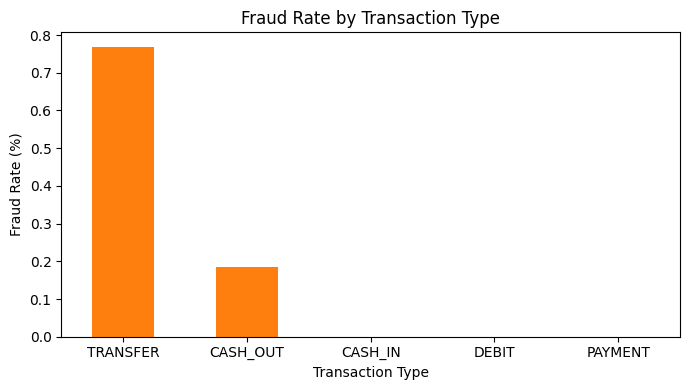

In [9]:
# Categorical Feature Analysis 

rows = []

feature = "type"
total_dataset_size = df.shape[0]

for value in sorted(df[feature].unique()):
    subset = df[df[feature] == value]

    total_count = subset.shape[0]
    fraud_count = int(subset[TARGET].sum())
    non_fraud_count = total_count - fraud_count

    percent_of_dataset = (total_count / total_dataset_size) * 100
    fraud_rate = (fraud_count / total_count) * 100 if total_count > 0 else 0.0

    rows.append({
        "Feature": feature,
        "Value": value,
        "Total Count": total_count,
        "Percentage of Dataset (%)": percent_of_dataset,
        "Fraud Count": fraud_count,
        "Non-Fraud Count": non_fraud_count,
        "Fraud Rate (%)": fraud_rate
    })

cat_summary = pd.DataFrame(rows).sort_values("Fraud Rate (%)", ascending=False)

# Display formatted table
display(
    cat_summary
    .style
    .format({
        "Total Count": "{:,}",
        "Fraud Count": "{:,}",
        "Non-Fraud Count": "{:,}",
        "Percentage of Dataset (%)": "{:.2f}%",
        "Fraud Rate (%)": "{:.2f}%"
    })
    .set_caption("Categorical Feature Analysis: Transaction Type")
)

# One clear plot: fraud rate by type 
plot_df = cat_summary.set_index("Value")["Fraud Rate (%)"]

plt.figure(figsize=(7, 4))
plot_df.plot(kind="bar", color="#ff7f0e")

plt.title("Fraud Rate by Transaction Type")
plt.xlabel("Transaction Type")
plt.ylabel("Fraud Rate (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [10]:
# Cell 7: Categorical Statistical Analysis + Chi-Square 

total_dataset_size = df.shape[0]

for feature in categorical_features:
    rows = []

    for value in sorted(df[feature].dropna().unique()):
        subset = df[df[feature] == value]

        total_count = subset.shape[0]
        fraud_count = int(subset[TARGET].sum())
        non_fraud_count = total_count - fraud_count

        percentage_of_dataset = (total_count / total_dataset_size) * 100
        fraud_rate = (fraud_count / total_count) * 100 if total_count > 0 else 0.0

        rows.append({
            "Feature": feature,
            "Value": value,
            "Total Count": total_count,
            "Percentage of Dataset (%)": percentage_of_dataset,
            "Fraud Count": fraud_count,
            "Non-Fraud Count": non_fraud_count,
            "Fraud Rate (%)": fraud_rate
        })

    cat_stats = pd.DataFrame(rows).sort_values(
        "Fraud Rate (%)", ascending=False
    )

    print("\n" + "=" * 80)
    print(f"Categorical Feature Analysis: {feature}")
    print("=" * 80)

    display(
        cat_stats
        .style
        .format({
            "Total Count": "{:,}",
            "Fraud Count": "{:,}",
            "Non-Fraud Count": "{:,}",
            "Percentage of Dataset (%)": "{:.2f}%",
            "Fraud Rate (%)": "{:.2f}%"
        })
        .set_caption(f"Categorical Statistical Summary for Feature: {feature}")
    )

    # Chi-Square Test (association between feature and target)
    contingency = pd.crosstab(df[feature], df[TARGET]).reindex(columns=[0, 1], fill_value=0)
    chi2, p_value, dof, _ = chi2_contingency(contingency)

    print(
        f"Chi-Square Test → χ² = {chi2:,.4f} | "
        f"DOF = {dof} | "
        f"P-value = {fmt_p_value(p_value)}"
    )


Categorical Feature Analysis: type


,Feature,Value,Total Count,Percentage of Dataset (%),Fraud Count,Non-Fraud Count,Fraud Rate (%)
4,type,TRANSFER,"532,909",8.38%,"4,097","528,812",0.77%
1,type,CASH_OUT,"2,237,500",35.17%,"4,116","2,233,384",0.18%
0,type,CASH_IN,"1,399,284",21.99%,0,"1,399,284",0.00%
2,type,DEBIT,"41,432",0.65%,0,"41,432",0.00%
3,type,PAYMENT,"2,151,495",33.81%,0,"2,151,495",0.00%


Chi-Square Test → χ² = 22,082.5357 | DOF = 4 | P-value = < 1e-10

Categorical Feature Analysis: isFlaggedFraud


,Feature,Value,Total Count,Percentage of Dataset (%),Fraud Count,Non-Fraud Count,Fraud Rate (%)
1,isFlaggedFraud,1,16,0.00%,16,0,100.00%
0,isFlaggedFraud,0,"6,362,604",100.00%,"8,197","6,354,407",0.13%


Chi-Square Test → χ² = 11,616.6658 | DOF = 1 | P-value = < 1e-10


In [11]:
# Cell 8: Numerical Descriptive Statistics 

rows = []

for feature in numerical_features:
    for cls in [0, 1]:
        values = df.loc[df[TARGET] == cls, feature].dropna()

        rows.append({
            "Feature": feature,
            "Class": "Fraud (1)" if cls == 1 else "Non-Fraud (0)",
            "Count": int(values.shape[0]),
            "Mean": float(values.mean()),
            "Median": float(values.median()),
            "Std": float(values.std()),
            "Min": float(values.min()),
            "Max": float(values.max())
        })

num_stats = pd.DataFrame(rows)

print("Numerical Descriptive Statistics (Fraud vs Non-Fraud):")
display(style_num_stats_table(num_stats))

Numerical Descriptive Statistics (Fraud vs Non-Fraud):


,Feature,Class,Count,Mean,Median,Std,Min,Max
0,step,Non-Fraud (0),"6,354,407",243.24,239.00,142.14,1.00,718.00
1,step,Fraud (1),"8,213",368.41,367.00,216.39,1.00,743.00
2,amount,Non-Fraud (0),"6,354,407","178,197.04","74,684.72","596,236.98",0.01,"92,445,516.64"
3,amount,Fraud (1),"8,213","1,467,967.30","441,423.44","2,404,252.95",0.00,"10,000,000.00"
4,oldbalanceOrg,Non-Fraud (0),"6,354,407","832,828.71","14,069.00","2,887,144.03",0.00,"43,818,855.30"
5,oldbalanceOrg,Fraud (1),"8,213","1,649,667.61","438,983.45","3,547,719.44",0.00,"59,585,040.37"
6,newbalanceOrig,Non-Fraud (0),"6,354,407","855,970.23",0.00,"2,924,986.96",0.00,"43,686,616.33"
7,newbalanceOrig,Fraud (1),"8,213","192,392.63",0.00,"1,965,666.46",0.00,"49,585,040.37"
8,oldbalanceDest,Non-Fraud (0),"6,354,407","1,101,420.87","133,311.80","3,399,201.79",0.00,"356,015,889.35"
9,oldbalanceDest,Fraud (1),"8,213","544,249.62",0.00,"3,336,420.95",0.00,"236,230,516.82"


In [12]:
# Cell 9: Mann–Whitney U Test 

mw_results = []

for feature in numerical_features:
    fraud_vals = df.loc[df[TARGET] == 1, feature].dropna()
    non_fraud_vals = df.loc[df[TARGET] == 0, feature].dropna()

    stat, p = mannwhitneyu(fraud_vals, non_fraud_vals, alternative="two-sided")

    mw_results.append({
        "Feature": feature,
        "U-Statistic": float(stat),
        "P-Value": float(p)
    })

mw_df = pd.DataFrame(mw_results).sort_values("P-Value")

print("Mann–Whitney U Test Results - formatted:")
display(style_mw_table(mw_df))

Mann–Whitney U Test Results - formatted:


,Feature,U-Statistic,P-Value
0,step,"34,829,829,709.5000",< 1e-10
1,amount,"41,224,999,611.0000",< 1e-10
2,oldbalanceOrg,"42,337,964,036.0000",< 1e-10
3,newbalanceOrig,"15,460,387,632.5000",< 1e-10
4,oldbalanceDest,"19,183,643,294.0000",< 1e-10
5,newbalanceDest,"23,982,267,530.0000",< 1e-10


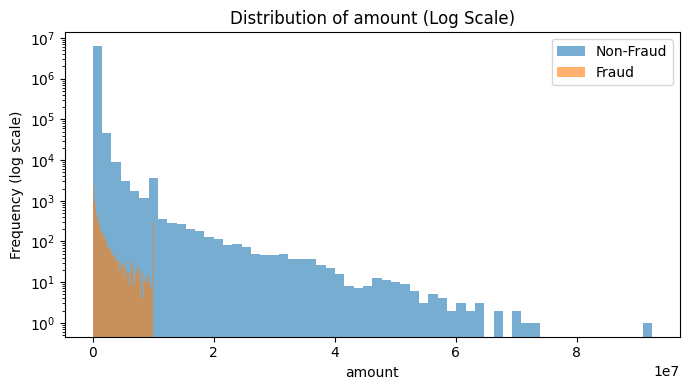

In [13]:
# Numerical Distributions 

# Choose which numerical features to plot (to avoid too many graphs)
PLOT_NUMERICAL_FEATURES = ["amount"]  # Example: keep only 'amount'
# PLOT_NUMERICAL_FEATURES = numerical_features  # Uncomment if you want all

for feature in PLOT_NUMERICAL_FEATURES:
    plt.figure(figsize=(7, 4))

    plt.hist(df.loc[df[TARGET] == 0, feature], bins=60, alpha=0.6, label="Non-Fraud", log=True)
    plt.hist(df.loc[df[TARGET] == 1, feature], bins=60, alpha=0.6, label="Fraud", log=True)

    plt.title(f"Distribution of {feature} (Log Scale)")
    plt.xlabel(feature)
    plt.ylabel("Frequency (log scale)")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [14]:
# Preprocessing: Imports

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer

print("Preprocessing libraries loaded.")

Preprocessing libraries loaded.


In [15]:
# Preprocessing: Define target and drop non-informative ID columns

TARGET = "isFraud"

# Columns that are identifiers (not suitable for generalization)
ID_COLUMNS = ["nameOrig", "nameDest"]

# Basic sanity check
required_cols = set([TARGET] + ID_COLUMNS + ["step", "type", "amount",
                                            "oldbalanceOrg", "newbalanceOrig",
                                            "oldbalanceDest", "newbalanceDest",
                                            "isFlaggedFraud"])
missing = required_cols - set(df.columns)
print("Missing required columns:", missing)

# Drop ID columns
df_work = df.drop(columns=ID_COLUMNS).copy()

print("Working dataset shape:", df_work.shape)
df_work.head()

Missing required columns: set()
Working dataset shape: (6362620, 9)


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [16]:
# Preprocessing - Cell 3: Basic data quality checks

print("Null counts (top 10):")
display(df_work.isna().sum().sort_values(ascending=False).head(10))

print("\nTarget distribution:")
display(df_work[TARGET].value_counts())

# Quick checks for unusual values
print("\nAmount summary:")
display(df_work["amount"].describe())

neg_amount = (df_work["amount"] < 0).sum()
print("Negative amounts:", int(neg_amount))

Null counts (top 10):


step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


Target distribution:


isFraud
0    6354407
1       8213
Name: count, dtype: int64


Amount summary:


count    6.362620e+06
mean     1.798619e+05
std      6.038582e+05
min      0.000000e+00
25%      1.338957e+04
50%      7.487194e+04
75%      2.087215e+05
max      9.244552e+07
Name: amount, dtype: float64

Negative amounts: 0


In [17]:
# Preprocessing: Feature engineering (time features)

# step: 1 step = 1 hour
df_work["hour"] = (df_work["step"] % 24).astype(np.int16)
df_work["day"] = (df_work["step"] // 24).astype(np.int16)

print("Added time features: hour, day")
df_work[["step", "hour", "day"]].head()

# Quick random sample (shows different days)

df_work[["step", "hour", "day", "type", "amount", TARGET]].sample(
    n=10, random_state=42
).sort_values(["day", "hour"]).reset_index(drop=True)

Added time features: hour, day


,step,hour,day,type,amount,isFraud
0,10,10,0,CASH_IN,152264.21,0
1,15,15,0,PAYMENT,11647.08,0
2,139,19,5,CASH_OUT,58605.72,0
3,188,20,7,CASH_OUT,20603.87,0
4,206,14,8,CASH_IN,78172.30,0
5,230,14,9,PAYMENT,4865.11,0
6,259,19,10,PAYMENT,915.13,0
7,278,14,11,CASH_IN,330218.42,0
8,403,19,16,TRANSFER,1551760.63,0
9,544,16,22,CASH_OUT,118131.63,0


In [18]:
# Preprocessing: Feature engineering (balance deltas & balance errors) + noise cleanup

# 1) Balance deltas
df_work["orig_delta"] = df_work["oldbalanceOrg"] - df_work["newbalanceOrig"]
df_work["dest_delta"] = df_work["newbalanceDest"] - df_work["oldbalanceDest"]

# 2) Balance errors compared to amount (useful in PaySim)
df_work["balance_error_orig"] = df_work["orig_delta"] - df_work["amount"]
df_work["balance_error_dest"] = df_work["dest_delta"] - df_work["amount"]

# 3) Clean floating-point numerical noise (treat very small residuals as zero)
epsilon = 1e-6
df_work["balance_error_orig"] = df_work["balance_error_orig"].where(
    df_work["balance_error_orig"].abs() > epsilon, 0.0
)
df_work["balance_error_dest"] = df_work["balance_error_dest"].where(
    df_work["balance_error_dest"].abs() > epsilon, 0.0
)

print("Added engineered balance features and cleaned numerical noise.")

# Display a clean preview (rounded for readability)
preview_cols = [
    "oldbalanceOrg", "newbalanceOrig", "orig_delta", "balance_error_orig",
    "oldbalanceDest", "newbalanceDest", "dest_delta", "balance_error_dest",
    "amount"
]

df_work[preview_cols].head().round(2)

Added engineered balance features and cleaned numerical noise.


,oldbalanceOrg,newbalanceOrig,orig_delta,balance_error_orig,oldbalanceDest,newbalanceDest,dest_delta,balance_error_dest,amount
0,170136.0,160296.36,9839.64,0.0,0.0,0.0,0.0,-9839.64,9839.64
1,21249.0,19384.72,1864.28,0.0,0.0,0.0,0.0,-1864.28,1864.28
2,181.0,0.00,181.00,0.0,0.0,0.0,0.0,-181.00,181.00
3,181.0,0.00,181.00,0.0,21182.0,0.0,-21182.0,-21363.00,181.00
4,41554.0,29885.86,11668.14,0.0,0.0,0.0,0.0,-11668.14,11668.14


In [19]:
# Preprocessing: Define feature configurations

# Always keep these core features
base_features = ["step", "hour", "day", "type", "amount"]

# Balance-related raw features (may carry simulator artifacts; evaluate carefully)
balance_raw_features = [
    "oldbalanceOrg", "newbalanceOrig",
    "oldbalanceDest", "newbalanceDest"
]

# Engineered balance features
balance_engineered_features = [
    "orig_delta", "dest_delta",
    "balance_error_orig", "balance_error_dest"
]

# Optional: rule-based flag as feature (we keep it for comparison)
rule_flag_feature = ["isFlaggedFraud"]

# Config A: Minimal / more realistic
FEATURES_A = base_features + rule_flag_feature

# Config B: Full feature set
FEATURES_B = base_features + balance_raw_features + balance_engineered_features + rule_flag_feature

print("Config A features:", FEATURES_A)
print("Config B features:", FEATURES_B)

Config A features: ['step', 'hour', 'day', 'type', 'amount', 'isFlaggedFraud']
Config B features: ['step', 'hour', 'day', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'orig_delta', 'dest_delta', 'balance_error_orig', 'balance_error_dest', 'isFlaggedFraud']


In [20]:
# Preprocessing: Select active feature set

ACTIVE_FEATURES = FEATURES_B  # start with full; later we can compare with FEATURES_A

X = df_work[ACTIVE_FEATURES].copy()
y = df_work[TARGET].astype(np.int8).copy()

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Fraud rate (%):", float(y.mean() * 100))

X shape: (6362620, 14)
y shape: (6362620,)
Fraud rate (%): 0.12908204481801522


In [21]:
# Preprocessing - Cell 8: Stratified train/val/test split

RANDOM_STATE = 42
TEST_SIZE = 0.20          # 20% test
VAL_SIZE_FROM_TRAIN = 0.20 # from remaining 80%, take 20% => 16% overall val

# First split: train+val vs test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    stratify=y,
    random_state=RANDOM_STATE
)

# Second split: train vs val
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=VAL_SIZE_FROM_TRAIN,
    stratify=y_trainval,
    random_state=RANDOM_STATE
)

print("Train:", X_train.shape, " Fraud%:", float(y_train.mean()*100))
print("Val:  ", X_val.shape,   " Fraud%:", float(y_val.mean()*100))
print("Test: ", X_test.shape,  " Fraud%:", float(y_test.mean()*100))

Train: (4072076, 14)  Fraud%: 0.1290742117779727
Val:   (1018020, 14)  Fraud%: 0.12907408498850712
Test:  (1272524, 14)  Fraud%: 0.12911347840983745


In [22]:
# Preprocessing - Cell 9: Build preprocessing pipeline (One-Hot + RobustScaler)

# Identify categorical vs numerical columns in ACTIVE_FEATURES
categorical_cols = ["type"]  # only 'type' is multi-class categorical
numeric_cols = [c for c in ACTIVE_FEATURES if c not in categorical_cols]

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

# Categorical pipeline: (impute -> one-hot)
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(
        handle_unknown="ignore",
        sparse_output=True
    ))
])

# Numeric pipeline: (impute -> robust scale)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_cols),
        ("num", numeric_transformer, numeric_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3
)

print("Preprocessor ready.")

Categorical columns: ['type']
Numeric columns: ['step', 'hour', 'day', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'orig_delta', 'dest_delta', 'balance_error_orig', 'balance_error_dest', 'isFlaggedFraud']
Preprocessor ready.


In [23]:
# Preprocessing: Fit on train, transform train/val/test

X_train_pp = preprocessor.fit_transform(X_train)
X_val_pp   = preprocessor.transform(X_val)
X_test_pp  = preprocessor.transform(X_test)

print("Transformed shapes:")
print("X_train_pp:", X_train_pp.shape)
print("X_val_pp:  ", X_val_pp.shape)
print("X_test_pp: ", X_test_pp.shape)

# Check sparse/dense
print("Is X_train_pp sparse?", hasattr(X_train_pp, "tocsr"))

Transformed shapes:
X_train_pp: (4072076, 18)
X_val_pp:   (1018020, 18)
X_test_pp:  (1272524, 18)
Is X_train_pp sparse? False


In [24]:
# Preprocessing - Cell 11: Bundle processed data (optional)

processed = {
    "ACTIVE_FEATURES": ACTIVE_FEATURES,
    "categorical_cols": categorical_cols,
    "numeric_cols": numeric_cols,
    "preprocessor": preprocessor,
    "X_train_pp": X_train_pp,
    "X_val_pp": X_val_pp,
    "X_test_pp": X_test_pp,
    "y_train": y_train,
    "y_val": y_val,
    "y_test": y_test
}

print("Preprocessing complete. Data is ready for model training.")

Preprocessing complete. Data is ready for model training.


In [25]:
# (define X_train_A / X_val_A / X_test_A and B)

# ---- A: For linear models (OneHot + RobustScaler) ----
# If your preprocessed arrays are named X_train_pp, X_val_pp, X_test_pp:
if "X_train_pp" in globals() and "X_val_pp" in globals() and "X_test_pp" in globals():
    X_train_A, X_val_A, X_test_A = X_train_pp, X_val_pp, X_test_pp
    print("Mapped A <- (X_train_pp, X_val_pp, X_test_pp)")
# If you used different naming:
elif "X_train" in globals() and "X_val" in globals() and "X_test" in globals():
    X_train_A, X_val_A, X_test_A = X_train, X_val, X_test
    print("Mapped A <- (X_train, X_val, X_test)")
else:
    raise NameError("Could not find preprocessed train/val/test arrays for A. Check your variable names.")

# ---- y ----
if "y_train" not in globals() or "y_val" not in globals() or "y_test" not in globals():
    raise NameError("y_train/y_val/y_test are not defined. Run the split cell first.")

# ---- B: For Gradient Boosting (optional) ----
# If you do NOT have a separate B pipeline yet, we temporarily set B = A
if "X_train_B" in globals() and "X_val_B" in globals() and "X_test_B" in globals():
    print("B already defined in notebook.")
else:
    X_train_B, X_val_B, X_test_B = X_train_A, X_val_A, X_test_A
    print("B not found -> temporarily set B = A (OK for now).")

print("Shapes:")
print("A:", X_train_A.shape, X_val_A.shape, X_test_A.shape)
print("y:", y_train.shape, y_val.shape, y_test.shape)

Mapped A <- (X_train_pp, X_val_pp, X_test_pp)
B not found -> temporarily set B = A (OK for now).
Shapes:
A: (4072076, 18) (1018020, 18) (1272524, 18)
y: (4072076,) (1018020,) (1272524,)


In [26]:
# Imports for modeling

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, average_precision_score
)

print("Modeling imports ready.")

Modeling imports ready.


In [27]:
import matplotlib.pyplot as plt

def compute_specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0.0

def evaluate_model(name, y_true, y_pred, y_score=None):
    out = {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "Specificity": compute_specificity(y_true, y_pred),
    }
    if y_score is not None:
        out["ROC-AUC"] = roc_auc_score(y_true, y_score)
        out["PR-AUC"]  = average_precision_score(y_true, y_score)
    else:
        out["ROC-AUC"] = np.nan
        out["PR-AUC"]  = np.nan
    return out

def plot_confusion_matrix_blue(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, cmap="Blues")
    plt.title(title)
    plt.colorbar()
    plt.xticks([0,1], ["Non-Fraud", "Fraud"])
    plt.yticks([0,1], ["Non-Fraud", "Fraud"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, f"{cm[i,j]:,}", ha="center", va="center")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

print("Evaluation helpers ready.")

Evaluation helpers ready.


In [28]:
# Threshold search (multi-metric)

def threshold_search(y_true, scores, thresholds=np.linspace(0.01, 0.99, 80)):
    rows = []
    for t in thresholds:
        pred = (scores >= t).astype(int)
        rows.append({
            "threshold": float(t),
            "precision": precision_score(y_true, pred, zero_division=0),
            "recall": recall_score(y_true, pred),
            "f1": f1_score(y_true, pred),
            "specificity": compute_specificity(y_true, pred),
        })
    return pd.DataFrame(rows)

print("Threshold tuning ready.")

Threshold tuning ready.


c:\Users\96279\OneDrive\Desktop\anasi\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


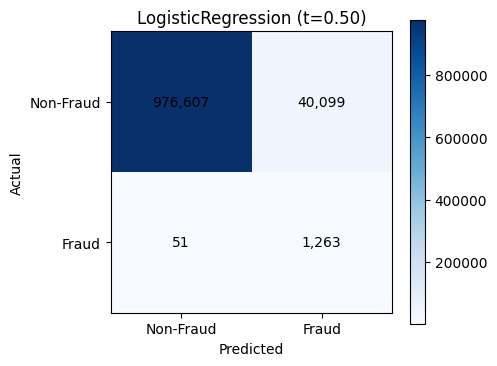

{'Model': 'LogisticRegression (t=0.50)',
 'Accuracy': 0.9605606962535117,
 'Precision': 0.030535273922924423,
 'Recall': 0.9611872146118722,
 'F1': 0.05919017714874871,
 'Specificity': np.float64(0.9605598865355374),
 'ROC-AUC': 0.9941412274906791,
 'PR-AUC': 0.6217084198136634}

In [29]:
# Logistic Regression (class-weighted)

lr = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=-1
)

lr.fit(X_train_A, y_train)

lr_val_score = lr.predict_proba(X_val_A)[:, 1]
lr_val_pred  = (lr_val_score >= 0.5).astype(int)

res_lr = evaluate_model("LogisticRegression (t=0.50)", y_val, lr_val_pred, lr_val_score)
plot_confusion_matrix_blue(y_val, lr_val_pred, "LogisticRegression (t=0.50)")

res_lr

In [30]:
# Threshold tuning for Logistic Regression

thr_lr = threshold_search(y_val, lr_val_score)
best_lr_f1 = thr_lr.loc[thr_lr["f1"].idxmax()]

best_lr_f1

threshold      0.990000
precision      0.499368
recall         0.601218
f1             0.545580
specificity    0.999221
Name: 79, dtype: float64

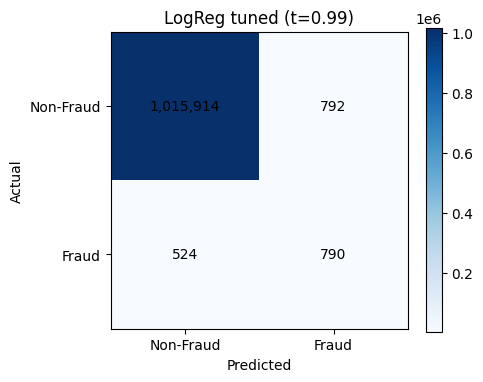

{'Model': 'LogReg tuned (t=0.99)',
 'Accuracy': 0.9987072945521699,
 'Precision': 0.4993678887484197,
 'Recall': 0.6012176560121766,
 'F1': 0.5455801104972375,
 'Specificity': np.float64(0.9992210137443863),
 'ROC-AUC': 0.9941412274906791,
 'PR-AUC': 0.6217084198136634}

In [31]:
# Logistic Regression (tuned threshold)

t_lr = float(best_lr_f1["threshold"])
lr_val_pred_t = (lr_val_score >= t_lr).astype(int)

res_lr_tuned = evaluate_model(f"LogReg tuned (t={t_lr:.2f})", y_val, lr_val_pred_t, lr_val_score)
plot_confusion_matrix_blue(y_val, lr_val_pred_t, f"LogReg tuned (t={t_lr:.2f})")

res_lr_tuned

c:\Users\96279\OneDrive\Desktop\anasi\.venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


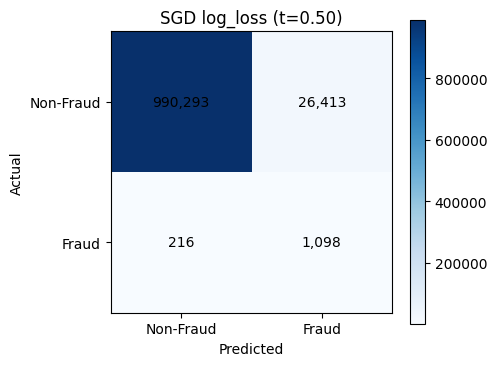

{'Model': 'SGD log_loss (t=0.50)',
 'Accuracy': 0.9738423606608907,
 'Precision': 0.03991130820399113,
 'Recall': 0.8356164383561644,
 'F1': 0.07618386816999133,
 'Specificity': np.float64(0.9740210050889835),
 'ROC-AUC': 0.9487804530511748,
 'PR-AUC': 0.03737599339310479}

In [32]:
# SGDClassifier (log_loss) - fast baseline

sgd_log = SGDClassifier(
    loss="log_loss",
    class_weight="balanced",
    max_iter=1000,
    n_jobs=-1,
    random_state=42
)

sgd_log.fit(X_train_A, y_train)

sgd_log_val_score = sgd_log.predict_proba(X_val_A)[:, 1]
sgd_log_val_pred  = (sgd_log_val_score >= 0.5).astype(int)

res_sgd_log = evaluate_model("SGD log_loss (t=0.50)", y_val, sgd_log_val_pred, sgd_log_val_score)
plot_confusion_matrix_blue(y_val, sgd_log_val_pred, "SGD log_loss (t=0.50)")

res_sgd_log

c:\Users\96279\OneDrive\Desktop\anasi\.venv\Lib\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class PassiveAggressiveClassifier is deprecated; this is deprecated in version 1.8 and will be removed in 1.10. Use `SGDClassifier(loss='hinge', penalty=None, learning_rate='pa1', eta0=1.0)` instead.
  warnings.warn(msg, category=FutureWarning)


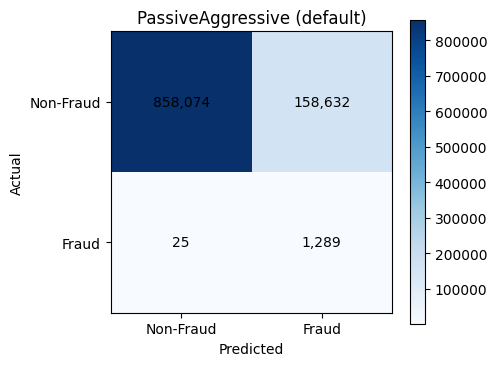

{'Model': 'PassiveAggressive (default)',
 'Accuracy': 0.8441513919176441,
 'Precision': 0.008060229738433351,
 'Recall': 0.9809741248097412,
 'F1': 0.015989084255899774,
 'Specificity': np.float64(0.843974560984198),
 'ROC-AUC': 0.9783310516789616,
 'PR-AUC': 0.5134808637012576}

In [33]:
# Passive-Aggressive (fast)

pa = PassiveAggressiveClassifier(
    class_weight="balanced",
    max_iter=1000,
    random_state=42
)

pa.fit(X_train_A, y_train)

# Uses decision_function (no predict_proba)
pa_val_score = pa.decision_function(X_val_A)
pa_val_pred  = (pa_val_score >= 0.0).astype(int)

res_pa = evaluate_model("PassiveAggressive (default)", y_val, pa_val_pred, pa_val_score)
plot_confusion_matrix_blue(y_val, pa_val_pred, "PassiveAggressive (default)")

res_pa

In [34]:
# Threshold tuning for Passive-Aggressive

thr_pa = threshold_search(y_val, pa_val_score, thresholds=np.linspace(np.percentile(pa_val_score, 1),
                                                                     np.percentile(pa_val_score, 99), 80))
best_pa_f1 = thr_pa.loc[thr_pa["f1"].idxmax()]
best_pa_f1

threshold      4.124293e+06
precision      8.673018e-02
recall         6.719939e-01
f1             1.536320e-01
specificity    9.908548e-01
Name: 79, dtype: float64

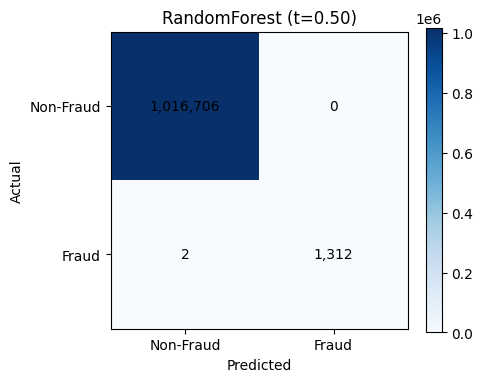

{'Model': 'RandomForest (t=0.50)',
 'Accuracy': 0.999998035402055,
 'Precision': 1.0,
 'Recall': 0.9984779299847792,
 'F1': 0.9992383853769993,
 'Specificity': np.float64(1.0),
 'ROC-AUC': 1.0,
 'PR-AUC': 1.0}

In [35]:
# RandomForest (balanced_subsample)

rf = RandomForestClassifier(
    n_estimators=200,
    n_jobs=-1,
    class_weight="balanced_subsample",
    random_state=42
)

rf.fit(X_train_A, y_train)

rf_val_score = rf.predict_proba(X_val_A)[:, 1]
rf_val_pred  = (rf_val_score >= 0.5).astype(int)

res_rf = evaluate_model("RandomForest (t=0.50)", y_val, rf_val_pred, rf_val_score)
plot_confusion_matrix_blue(y_val, rf_val_pred, "RandomForest (t=0.50)")

res_rf

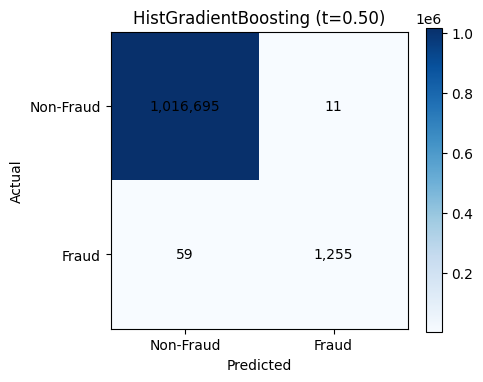

{'Model': 'HistGradientBoosting (t=0.50)',
 'Accuracy': 0.9999312390719239,
 'Precision': 0.9913112164296999,
 'Recall': 0.9550989345509894,
 'F1': 0.9728682170542635,
 'Specificity': np.float64(0.9999891807464498),
 'ROC-AUC': 0.9977847668179592,
 'PR-AUC': 0.9909124279240005}

In [36]:
# HistGradientBoosting (Gradient Boosting)
# Uses Preprocessor B (dense + ordinal)

hgb = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=8,
    max_iter=300,
    random_state=42
)

hgb.fit(X_train_B, y_train)

hgb_val_score = hgb.predict_proba(X_val_B)[:, 1]
hgb_val_pred  = (hgb_val_score >= 0.5).astype(int)

res_hgb = evaluate_model("HistGradientBoosting (t=0.50)", y_val, hgb_val_pred, hgb_val_score)
plot_confusion_matrix_blue(y_val, hgb_val_pred, "HistGradientBoosting (t=0.50)")

res_hgb

In [37]:
# Threshold tuning for HGB

thr_hgb = threshold_search(y_val, hgb_val_score)
best_hgb_f1 = thr_hgb.loc[thr_hgb["f1"].idxmax()]
best_hgb_f1

threshold      0.220886
precision      0.990144
recall         0.993912
f1             0.992024
specificity    0.999987
Name: 17, dtype: float64

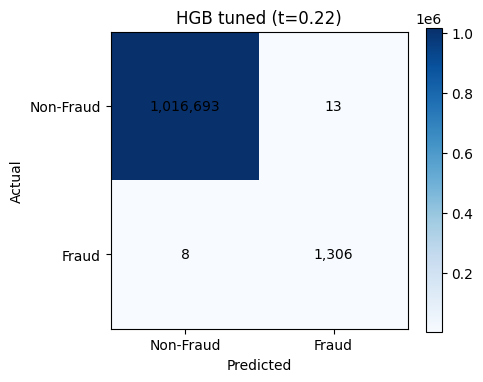

{'Model': 'HGB tuned (t=0.22)',
 'Accuracy': 0.9999793717215771,
 'Precision': 0.9901440485216073,
 'Recall': 0.9939117199391172,
 'F1': 0.9920243068742879,
 'Specificity': np.float64(0.9999872136094407),
 'ROC-AUC': 0.9977847668179592,
 'PR-AUC': 0.9909124279240005}

In [38]:
# HGB tuned threshold

t_hgb = float(best_hgb_f1["threshold"])
hgb_val_pred_t = (hgb_val_score >= t_hgb).astype(int)

res_hgb_tuned = evaluate_model(f"HGB tuned (t={t_hgb:.2f})", y_val, hgb_val_pred_t, hgb_val_score)
plot_confusion_matrix_blue(y_val, hgb_val_pred_t, f"HGB tuned (t={t_hgb:.2f})")

res_hgb_tuned

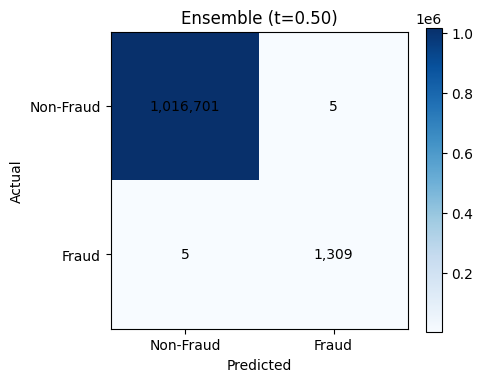

{'Model': 'Ensemble (t=0.50)',
 'Accuracy': 0.9999901770102748,
 'Precision': 0.9961948249619482,
 'Recall': 0.9961948249619482,
 'F1': 0.9961948249619482,
 'Specificity': np.float64(0.9999950821574772),
 'ROC-AUC': 0.9999998510425172,
 'PR-AUC': 0.9998828663119004}

In [39]:
# Manual soft voting ensemble (LR + RF + HGB)

w_lr, w_rf, w_hgb = 1.0, 1.0, 2.0
ens_val_score = (w_lr*lr_val_score + w_rf*rf_val_score + w_hgb*hgb_val_score) / (w_lr + w_rf + w_hgb)

ens_val_pred = (ens_val_score >= 0.5).astype(int)

res_ens = evaluate_model("Ensemble (t=0.50)", y_val, ens_val_pred, ens_val_score)
plot_confusion_matrix_blue(y_val, ens_val_pred, "Ensemble (t=0.50)")

res_ens

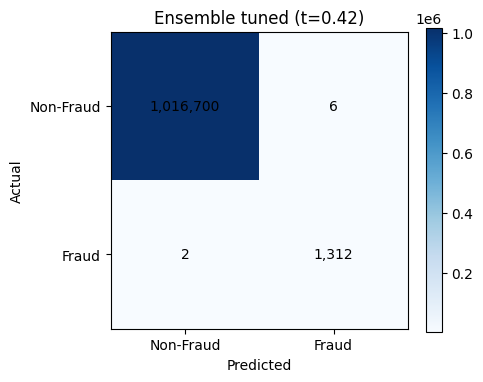

(threshold      0.419367
 precision      0.995448
 recall         0.998478
 f1             0.996960
 specificity    0.999994
 Name: 33, dtype: float64,
 {'Model': 'Ensemble tuned (t=0.42)',
  'Accuracy': 0.9999921416082199,
  'Precision': 0.9954476479514416,
  'Recall': 0.9984779299847792,
  'F1': 0.9969604863221885,
  'Specificity': np.float64(0.9999940985889726),
  'ROC-AUC': 0.9999998510425172,
  'PR-AUC': 0.9998828663119004})

In [40]:
# Tune threshold for Ensemble and apply best

thr_ens = threshold_search(y_val, ens_val_score)
best_ens_f1 = thr_ens.loc[thr_ens["f1"].idxmax()]

t_ens = float(best_ens_f1["threshold"])
ens_val_pred_t = (ens_val_score >= t_ens).astype(int)

res_ens_tuned = evaluate_model(f"Ensemble tuned (t={t_ens:.2f})", y_val, ens_val_pred_t, ens_val_score)
plot_confusion_matrix_blue(y_val, ens_val_pred_t, f"Ensemble tuned (t={t_ens:.2f})")

best_ens_f1, res_ens_tuned

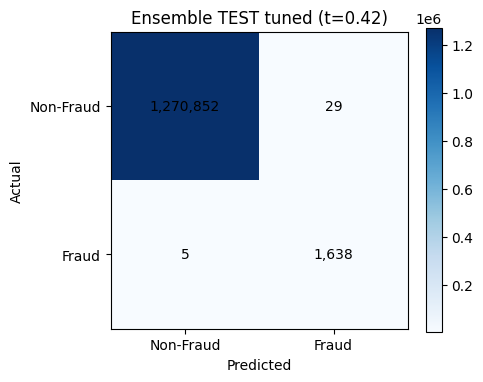

{'Model': 'Ensemble TEST tuned (t=0.42)',
 'Accuracy': 0.9999732814469511,
 'Precision': 0.9826034793041392,
 'Recall': 0.996956786366403,
 'F1': 0.9897280966767371,
 'Specificity': np.float64(0.9999771811837616),
 'ROC-AUC': 0.9995361540532838,
 'PR-AUC': 0.9973459373894767}

In [41]:
# Final evaluation on TEST (Ensemble tuned)

# Compute TEST scores
lr_test_score  = lr.predict_proba(X_test_A)[:, 1]
rf_test_score  = rf.predict_proba(X_test_A)[:, 1]
hgb_test_score = hgb.predict_proba(X_test_B)[:, 1]

ens_test_score = (w_lr*lr_test_score + w_rf*rf_test_score + w_hgb*hgb_test_score) / (w_lr + w_rf + w_hgb)
ens_test_pred  = (ens_test_score >= t_ens).astype(int)

res_test = evaluate_model(f"Ensemble TEST tuned (t={t_ens:.2f})", y_test, ens_test_pred, ens_test_score)
plot_confusion_matrix_blue(y_test, ens_test_pred, f"Ensemble TEST tuned (t={t_ens:.2f})")

res_test

In [42]:
# Summary table (validation)

summary = pd.DataFrame([
    res_lr,
    res_lr_tuned,
    res_sgd_log,
    res_pa,
    res_rf,
    res_hgb,
    res_hgb_tuned,
    res_ens,
    res_ens_tuned
])

summary.sort_values(["PR-AUC", "F1", "Precision"], ascending=False)

,Model,Accuracy,Precision,Recall,F1,Specificity,ROC-AUC,PR-AUC
4,RandomForest (t=0.50),0.999998,1.000000,0.998478,0.999238,1.000000,1.000000,1.000000
8,Ensemble tuned (t=0.42),0.999992,0.995448,0.998478,0.996960,0.999994,1.000000,0.999883
7,Ensemble (t=0.50),0.999990,0.996195,0.996195,0.996195,0.999995,1.000000,0.999883
6,HGB tuned (t=0.22),0.999979,0.990144,0.993912,0.992024,0.999987,0.997785,0.990912
5,HistGradientBoosting (t=0.50),0.999931,0.991311,0.955099,0.972868,0.999989,0.997785,0.990912
1,LogReg tuned (t=0.99),0.998707,0.499368,0.601218,0.545580,0.999221,0.994141,0.621708
0,LogisticRegression (t=0.50),0.960561,0.030535,0.961187,0.059190,0.960560,0.994141,0.621708
3,PassiveAggressive (default),0.844151,0.008060,0.980974,0.015989,0.843975,0.978331,0.513481
2,SGD log_loss (t=0.50),0.973842,0.039911,0.835616,0.076184,0.974021,0.948780,0.037376


In [43]:
import joblib
import numpy as np
import pandas as pd
import os

print("=" * 60)
print("Starting model saving process...")
print("=" * 60)

# Check for required variables
required_vars = {
    'preprocessor': 'preprocessor',
    'lr': 'lr',
    'rf': 'rf',
    'hgb': 'hgb',
    'w_lr': 'w_lr',
    'w_rf': 'w_rf',
    'w_hgb': 'w_hgb',
    't_ens': 't_ens',
    'X_test': 'X_test',
    'y_test': 'y_test',
    'ACTIVE_FEATURES': 'ACTIVE_FEATURES'
}

missing_vars = []
for var_name, var_display in required_vars.items():
    if var_name not in globals():
        missing_vars.append(var_display)

if missing_vars:
    print("\n[ERROR] The following variables are missing:")
    for var in missing_vars:
        print(f"   - {var}")
    print("\n[WARNING] Please make sure:")
    print("   1. All Notebook cells are executed")
    print("   2. All models are trained")
    print("   3. Evaluation cells are executed")
    raise NameError("Some required variables are missing")

print("\n[OK] All required variables found\n")

try:
    # Save preprocessor
    joblib.dump(preprocessor, 'preprocessor.pkl')
    print("[OK] Preprocessor saved (preprocessor.pkl)")
    
    # Save models
    joblib.dump(lr, 'logistic_regression.pkl')
    print("[OK] Logistic Regression saved (logistic_regression.pkl)")
    
    joblib.dump(rf, 'random_forest.pkl')
    print("[OK] Random Forest saved (random_forest.pkl)")
    
    joblib.dump(hgb, 'hist_gradient_boosting.pkl')
    print("[OK] HistGradientBoosting saved (hist_gradient_boosting.pkl)")
    
    # Save Ensemble configuration
    ensemble_config = {
        'w_lr': w_lr,
        'w_rf': w_rf,
        'w_hgb': w_hgb,
        'threshold': t_ens
    }
    joblib.dump(ensemble_config, 'ensemble_config.pkl')
    print("[OK] Ensemble config saved (ensemble_config.pkl)")
    
    # Save test data (small sample to save memory)
    np.random.seed(42)  # For reproducibility
    test_sample_size = min(10000, len(X_test))
    test_indices = np.random.choice(len(X_test), test_sample_size, replace=False)
    
    if hasattr(X_test, 'iloc'):
        test_data = {
            'X_test': X_test.iloc[test_indices].copy(),
            'y_test': y_test.iloc[test_indices].copy() if hasattr(y_test, 'iloc') else y_test[test_indices]
        }
    else:
        test_data = {
            'X_test': X_test[test_indices].copy(),
            'y_test': y_test[test_indices].copy()
        }
    
    joblib.dump(test_data, 'test_data.pkl')
    print(f"[OK] Test data saved ({test_sample_size} samples) (test_data.pkl)")
    
    # Save active features list
    joblib.dump(ACTIVE_FEATURES, 'active_features.pkl')
    print("[OK] Active features saved (active_features.pkl)")
    
    print("\n" + "=" * 60)
    print("[SUCCESS] All files saved successfully!")
    print("=" * 60)
    
    # Show file sizes
    print("\n[INFO] Saved file sizes:")
    files = [
        'preprocessor.pkl',
        'logistic_regression.pkl',
        'random_forest.pkl',
        'hist_gradient_boosting.pkl',
        'ensemble_config.pkl',
        'test_data.pkl',
        'active_features.pkl'
    ]
    
    total_size = 0
    for file in files:
        if os.path.exists(file):
            size = os.path.getsize(file) / (1024 * 1024)  # in MB
            total_size += size
            print(f"   {file}: {size:.2f} MB")
    
    print(f"\n   Total size: {total_size:.2f} MB")
    print("\n[SUCCESS] You can now run: streamlit run app.py")
    
except Exception as e:
    print(f"\n[ERROR] An error occurred while saving: {str(e)}")
    print("\n[WARNING] Please check:")
    print("   1. Sufficient disk space")
    print("   2. Write permissions in current directory")
    raise

Starting model saving process...

[OK] All required variables found

[OK] Preprocessor saved (preprocessor.pkl)
[OK] Logistic Regression saved (logistic_regression.pkl)
[OK] Random Forest saved (random_forest.pkl)
[OK] HistGradientBoosting saved (hist_gradient_boosting.pkl)
[OK] Ensemble config saved (ensemble_config.pkl)
[OK] Test data saved (10000 samples) (test_data.pkl)
[OK] Active features saved (active_features.pkl)

[SUCCESS] All files saved successfully!

[INFO] Saved file sizes:
   preprocessor.pkl: 0.00 MB
   logistic_regression.pkl: 0.00 MB
   random_forest.pkl: 6.93 MB
   hist_gradient_boosting.pkl: 0.07 MB
   ensemble_config.pkl: 0.00 MB
   test_data.pkl: 1.16 MB
   active_features.pkl: 0.00 MB

   Total size: 8.15 MB

[SUCCESS] You can now run: streamlit run app.py


In [44]:
exec(open('save_test_data_simple.py', encoding='utf-8').read())

Saving Full Test Dataset with Account Names

[OK] Original dataframe found

[INFO] Sampling 10000 transactions from original dataframe...
[INFO] Fraud rate in dataset: 0.0013

[OK] Full test data saved as CSV: test_data_full.csv
     Rows: 10000
     Columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']

[INFO] Sample of saved data:
            nameOrig     nameDest      type    amount  isFraud
6225780    C35037313  M1717030987   PAYMENT  14242.63        0
1929317  C1501472962  M1509949740   PAYMENT    326.96        0
4458618  C1795481583  M1449655508   PAYMENT   7866.30        0
485385   C1608584426  C2100990049  CASH_OUT  89516.99        0
2442049  C1788489144  M2116975914   PAYMENT  14608.62        0

[OK] Full test data saved as pickle: test_data_full.pkl

[SUCCESS] Test data files saved successfully!

[INFO] Saved file sizes:
   test_data_full.csv: 0.75 MB
   test_data_full.pk